# `Deepfake Classification - ViT`

In [ ]:
!pip install evaluate datasets accelerate
!pip install git+https://github.com/huggingface/transformers.git

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import gc
import numpy as np
import pandas as pd
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, f1_score
from imblearn.over_sampling import RandomOverSampler
import evaluate
from datasets import Dataset, Image, ClassLabel
from transformers import (
    TrainingArguments,
    Trainer,
    ViTImageProcessor,
    ViTForImageClassification,
    DefaultDataCollator
)
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomRotation,
    RandomResizedCrop,
    RandomHorizontalFlip,
    RandomAdjustSharpness,
    Resize,
    ToTensor
)
from PIL import Image as PILImage
from PIL import ImageFile

# Enable loading truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from datasets import load_dataset
dataset = load_dataset("Hemg/deepfake-and-real-images", split="train")

README.md:   0%|          | 0.00/394 [00:00<?, ?B/s]

train-00000-of-00005.parquet:   0%|          | 0.00/366M [00:00<?, ?B/s]

train-00001-of-00005.parquet:   0%|          | 0.00/356M [00:00<?, ?B/s]

train-00002-of-00005.parquet:   0%|          | 0.00/347M [00:00<?, ?B/s]

train-00003-of-00005.parquet:   0%|          | 0.00/348M [00:00<?, ?B/s]

train-00004-of-00005.parquet:   0%|          | 0.00/377M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/190335 [00:00<?, ? examples/s]

In [ ]:
file_names = []
labels = []

for example in dataset:
    file_path = example['image'].filename  # Get the file path
    label = example['label']  # Get the label
    file_names.append(file_path)  # Add the file path to the list
    labels.append(label)  # Add the label to the list

In [ ]:
# Print the total number of file names and labels
print(len(file_names), len(labels))

190335 190335


In [ ]:
# Create a pandas dataframe from the collected file names and labels
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})

In [ ]:
print(df.shape)

(190335, 2)


In [ ]:
df.head()

,image,label
0,,0
1,,0
2,,0
3,,0
4,,0


In [ ]:
df['label'].unique()

array([0, 1])

In [ ]:
y = df[['label']]
df = df.drop(['label'], axis=1)
ros = RandomOverSampler(random_state=83)
df, y_resampled = ros.fit_resample(df, y)
del y
df['label'] = y_resampled
del y_resampled
gc.collect()

243

In [ ]:
import pandas as pd

# Create a DataFrame from the collected file names and labels
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})

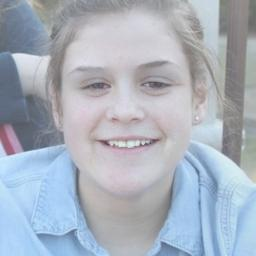

In [ ]:
dataset[10]["image"]

In [ ]:
labels_subset = labels[:5]

# Printing the subset of labels to inspect the content.
print(labels_subset)

[0, 0, 0, 0, 0]


In [ ]:
# Define the list of unique labels
labels_list = ['Real', 'Fake']

# Initialize dictionaries to map labels to IDs and vice versa
label2id, id2label = dict(), dict()
for i, label in enumerate(labels_list):
    label2id[label] = i
    id2label[i] = label

# Create ClassLabels object
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

In [ ]:
# Print the resulting dictionaries for reference
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'Real', 1: 'Fake'} 

Mapping of Labels to IDs: {'Real': 0, 'Fake': 1}


In [ ]:

# Mapping labels to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

# Casting label column to ClassLabel Object
dataset = dataset.cast_column('label', ClassLabels)

# Splitting the dataset into training and testing sets using an 60-40 split ratio.
dataset = dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")

# Extracting the training data from the split dataset.
train_data = dataset['train']

# Extracting the testing data from the split dataset.
test_data = dataset['test']

Map:   0%|          | 0/190335 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/190335 [00:00<?, ? examples/s]

In [ ]:
# Define the pre-trained ViT model string
model_str = "google/vit-base-patch16-224-in21k"

# Create a processor for ViT model input
processor = ViTImageProcessor.from_pretrained(model_str)

# Retrieve the image mean and standard deviation used for normalization
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

# Define transformations for training and validation data
_train_transforms = Compose(
    [
        Resize((size, size)),
        RandomRotation(90),
        RandomAdjustSharpness(2),
        ToTensor(),
        Normalize(mean=image_mean, std=image_std)
    ]
)

_val_transforms = Compose(
    [
        Resize((size, size)),
        ToTensor(),
        Normalize(mean=image_mean, std=image_std)
    ]
)

# Define functions to apply transformations
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Set transforms for training and test data
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
# Create a ViTForImageClassification model
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))
model.config.id2label = id2label
model.config.label2id = label2id

# Calculate and print the number of trainable parameters in millions for the model.
print(model.num_parameters(only_trainable=True) / 1e6)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


85.800194


In [ ]:
# Load the accuracy metric from a module named 'evaluate'
accuracy = evaluate.load("accuracy")

# Define a function 'compute_metrics' to calculate evaluation metrics
def compute_metrics(eval_pred):
    # Extract model predictions from the evaluation prediction object
    predictions = eval_pred.predictions

    # Extract true labels from the evaluation prediction object
    label_ids = eval_pred.label_ids

    # Calculate accuracy using the loaded accuracy metric
    # Convert model predictions to class labels by selecting the class with the highest probability (argmax)
    predicted_labels = predictions.argmax(axis=1)

    # Calculate accuracy score by comparing predicted labels to true labels
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']

    # Return the computed accuracy as a dictionary with the key "accuracy"
    return {
        "accuracy": acc_score
    }

In [ ]:
# Define training arguments
args = TrainingArguments(
    output_dir="Deep-Fake-Detector-Model",
    logging_dir='./logs',
    evaluation_strategy="epoch",
    learning_rate=1e-6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none"
)

In [ ]:
# Create a Trainer instance
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [ ]:
trainer.evaluate()

{'eval_loss': 0.698646068572998,
 'eval_model_preparation_time': 0.0053,
 'eval_accuracy': 0.501471090445793,
 'eval_runtime': 363.9299,
 'eval_samples_per_second': 209.2,
 'eval_steps_per_second': 26.151}

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,0.227800,0.514502,0.005300,0.691610
2,0.186500,0.495183,0.005300,0.699871


TrainOutput(global_step=7138, training_loss=0.2889665345512341, metrics={'train_runtime': 3051.3234, 'train_samples_per_second': 74.853, 'train_steps_per_second': 2.339, 'total_flos': 1.7699325411952042e+19, 'train_loss': 0.2889665345512341, 'epoch': 2.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.49518314003944397,
 'eval_model_preparation_time': 0.0053,
 'eval_accuracy': 0.6998712795859932,
 'eval_runtime': 359.7866,
 'eval_samples_per_second': 211.609,
 'eval_steps_per_second': 26.452,
 'epoch': 2.0}

In [ ]:
outputs = trainer.predict(test_data)
print(outputs.metrics)

{'test_loss': 0.49518314003944397, 'test_model_preparation_time': 0.0053, 'test_accuracy': 0.6998712795859932, 'test_runtime': 381.0474, 'test_samples_per_second': 199.802, 'test_steps_per_second': 24.976}


Accuracy: 0.6999
F1 Score: 0.6739


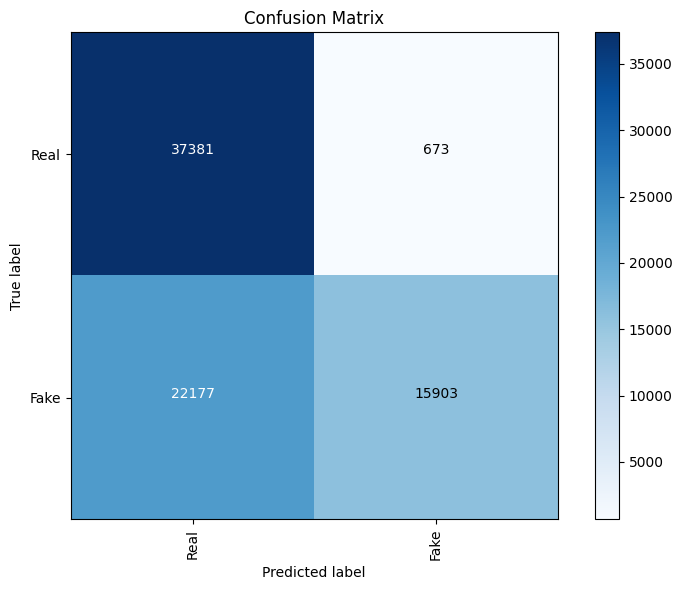


Classification report:

              precision    recall  f1-score   support

        Real     0.6276    0.9823    0.7659     38054
        Fake     0.9594    0.4176    0.5819     38080

    accuracy                         0.6999     76134
   macro avg     0.7935    0.7000    0.6739     76134
weighted avg     0.7936    0.6999    0.6739     76134



In [ ]:
# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)

    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a small number of labels
if len(labels_list) <= 150:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

In [ ]:
trainer.save_model()

In [ ]:
# Import the 'pipeline' function from the 'transformers' library.
from transformers import pipeline
pipe = pipeline('image-classification', model=model_name, device=0)

In [ ]:
image = test_data[1]["image"]
image

In [ ]:
pipe(image)

In [ ]:
id2label[test_data[1]["label"]]

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
# Import the HfApi class from the huggingface_hub library.
from huggingface_hub import HfApi

api = HfApi()
repo_id = f"prithivMLmods/{model_name}"

try:
    # Attempt to create a new repository on the Hugging Face Model Hub using the specified repo_id.
    api.create_repo(repo_id)

    # If the repository creation is successful, print a message indicating that the repository was created.
    print(f"Repo {repo_id} created")
except:
    # If an exception is raised, print a message indicating that the repository already exists.
    print(f"Repo {repo_id} already exists")

In [ ]:
api.upload_folder(
    folder_path=model_name,  # The path to the folder to be uploaded
    path_in_repo=".",  # The path where the folder will be stored in the repository
    repo_id=repo_id,  # The ID of the repository where the folder will be uploaded
    repo_type="model",  # The type of the repository (in this case, a model repository)
    revision="main" # Revision name
)